## Import packages and set config

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,3"

import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import Dataset

import random

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Smaller than the original GPT-2, only 6 layers (instead of 12), 12 heads, 768 dimensions (like GPT-2)
model_name = "gpt2-medium" # "gpt2-medium" # distilgpt2 #gpt2-large it reachs the maximum gpu capacity
experiment_name = "yelp"

## Load data

In [3]:
df = pd.read_csv(f"/hadatasets/fillipe.silva/LLMSegm/data/{experiment_name}/train.csv")
columns = df.columns.tolist()
ds = Dataset.from_pandas(df)
print(df.shape, df.head())

(37344, 26)    review_count  useful_user  funny_user  cool_user      fans  average_stars  \
0     -0.436465    -0.214581   -0.159044  -0.167304 -0.232373       0.995970   
1     -0.424311    -0.212954   -0.159044  -0.163708 -0.232373       1.116056   
2      2.961771     3.285855    1.302974   2.933231  3.216466       0.549938   
3     -0.300341    -0.204819   -0.155936  -0.161139 -0.162559       0.567093   
4     -0.229848    -0.183668   -0.148168  -0.156001 -0.190484      -0.359283   

   compliment_hot  compliment_more  compliment_profile  compliment_cute  ...  \
0       -0.119834        -0.088258           -0.039402        -0.066958  ...   
1       -0.119834        -0.088258           -0.039402        -0.066958  ...   
2        0.595663         0.908732            0.158631         0.079997  ...   
3       -0.114110        -0.088258           -0.039402        -0.066958  ...   
4       -0.114110        -0.088258           -0.039402        -0.066958  ...   

   compliment_photos     s

In [4]:
def combine_data_ordered(sample):
    concat = ""
    for col in columns:
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

def combine_data_shuffled(sample):
    concat = ""
    for col in random.sample(columns, k=len(columns)):
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

# Shuffle the features or not
shuffle = True 
if shuffle:
    combined_ds = ds.map(combine_data_shuffled)
else:
    combined_ds = ds.map(combine_data_ordered)

combined_ds = combined_ds.remove_columns(ds.column_names)
print(combined_ds["concat"][0])

Map:   0%|          | 0/37344 [00:00<?, ? examples/s]

Map: 100%|██████████| 37344/37344 [00:09<00:00, 3848.44 examples/s]


useful_user is -0.2145809057776013, cool_review is -0.3857819574302367, useful_review is -0.5261577724615858, compliment_writer is -0.1322368124227246, compliment_funny is -0.1362365269175, compliment_more is -0.088257527134576, review_count is -0.4364647902773408, compliment_list is -0.0439897434822456, compliment_cool is -0.1362365269175, compliment_profile is -0.0394022516789422, compliment_note is -0.156450259749963, text is New favorite, don't go at peak lunch though (too crowded) Perfect brisket, great sides and sauce!, funny_review is -0.3097658360465847, compliment_hot is -0.1198341496823664, elite_count is -0.5121504816011141, compliment_cute is -0.0669580274633039, compliment_plain is -0.1225147908919149, yelp_since_YRMO is 0.6282788162521304, friend_count is -0.404603654155143, yelp_since_year is 0.6126004079611385, funny_user is -0.1590435484890861, stars is 0.8827599034766418, cool_user is -0.167303877508685, fans is -0.232373053979433, compliment_photos is -0.100955400854

### Tokenize the data

In [5]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

max_length = 125
def tokenizer_function(sample):
    result = tokenizer(sample["concat"], truncation=True, padding="max_length", max_length=max_length)
    result["labels"] = result["input_ids"].copy()
    return result

# Tokenize dataset and create pytorch tensors
tokenizer_ds = combined_ds.map(tokenizer_function, batched=True)
tokenizer_ds.set_format("torch")

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 37344/37344 [00:09<00:00, 4054.49 examples/s]


### Train Model

In [6]:
model = AutoModelForCausalLM.from_pretrained(model_name)
epochs = 25
batch_size = 4
training_args = TrainingArguments(f"/hadatasets/fillipe.silva/LLMSegm/models/{experiment_name}", 
                                  num_train_epochs=epochs, 
                                  per_device_train_batch_size=batch_size,
                                  save_steps=5000)
trainer = Trainer(model, training_args, train_dataset=tokenizer_ds, tokenizer=tokenizer)

In [7]:
trainer.train() # resume_from_checkpoint = True

/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,1.587500
1000,1.184900
1500,1.085000
2000,1.005000
2500,0.992300
3000,0.980500
3500,0.926400
4000,0.901100
4500,0.867900
5000,0.880900


/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/fillipe.silva/miniconda3/envs/llmsegm/lib/python3.12/site-packages/torch/

TrainOutput(global_step=77800, training_loss=0.5097872004962519, metrics={'train_runtime': 36595.6496, 'train_samples_per_second': 25.511, 'train_steps_per_second': 2.126, 'total_flos': 2.116784590848e+17, 'train_loss': 0.5097872004962519, 'epoch': 25.0})

### Save Model

In [8]:
model_name = model_name + "_" + str(epochs) + ".pt"
model_path = f"/hadatasets/fillipe.silva/LLMSegm/models/{experiment_name}/{model_name}"
torch.save(model.state_dict(), model_path)

### Look at loss curve

The trainer.state.log_history contains some information about the training.
Just saving the loss curve, but one could also save the whole state of the trainer.

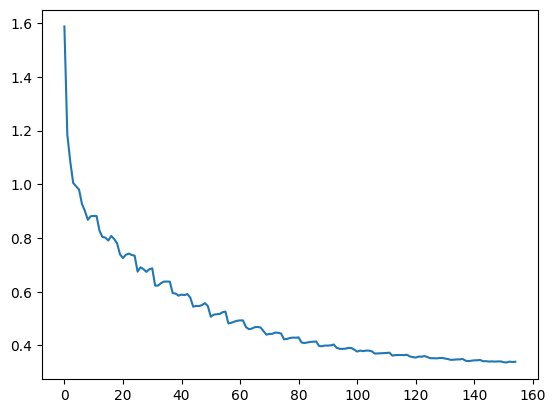

In [9]:
rounds = len(trainer.state.log_history) - 1
loss = [x["loss"] if i < rounds else None for i, x in enumerate(trainer.state.log_history)]
plt.plot(loss)

## Getting Embeddings 

In [11]:
val_df = pd.read_csv(f"/hadatasets/fillipe.silva/LLMSegm/data/{experiment_name}/test.csv")
columns = val_df.columns.tolist()
ds = Dataset.from_pandas(val_df)

In [12]:
def combine_data_ordered(sample):
    concat = ""
    for col in columns:
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

def combine_data_shuffled(sample):
    concat = ""
    for col in random.sample(columns, k=len(columns)):
        concat += "%s is %s, " % (col, str(sample[col]).strip())

    return {"concat": concat}

combined_ds = ds.map(combine_data_shuffled)
combined_ds["concat"][0]

Map: 100%|██████████| 9336/9336 [00:02<00:00, 3416.42 examples/s]


"cool_review is -0.3857819574302367, cool_user is -0.13596458092566, review_count is -0.2857561731506774, compliment_profile is -0.0213992701818918, compliment_more is -0.0095478482571435, text is I've never been inside I have only ordered ice cream in the drive thru. It has been 2 years of going and they have not messed up my order. The only issue is that when its busy during the summer if the line is long I won't order a banana split. The reason is they make it right away sometimes and its already starting to melt by the time I get it. And by the time I get home its already soup. I only line 2 miles down the street., fans is -0.1765214126506289, yelp_since_YRMO is 1.4064131223699734, stars is -0.7321808614982132, funny_user is -0.1497214395035361, compliment_cool is -0.0719265294452116, elite_count is 0.1788710190731522, compliment_funny is -0.0719265294452116, useful_user is -0.1783807162281949, useful_review is -0.5261577724615858, compliment_note is -0.0845846983526729, friend_cou

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

embs = []
for text in combined_ds["concat"]:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model(**inputs)

    # Extract logits
    logits = outputs.logits

    # Use logits as text embeddings
    text_embedding = logits[:, -1, :]  # Take the last token's logits as the embedding

    # Convert tensor to numpy array if needed
    text_embedding_np = text_embedding.detach().cpu().numpy()

    embs.append(text_embedding_np[0])

'''other option to do embds (not tested)
token_ids = tokenizer.encode("Your input text goes here", add_special_tokens=False)

# Convert token IDs to tensor and move it to the model's device
tokens_tensor = torch.tensor([token_ids], device=model.device)
with torch.no_grad():
# Forward pass through the model
outputs = model(tokens_tensor)
# Retrieve the hidden states from the model output
hidden_states = outputs[0]  # 'outputs' is a tuple, the first element is the hidden states

# Averaging over the sequence length
print(len((hidden_states[0].mean(dim=0))), (hidden_states[0].mean(dim=0)))
'''

'other option to do embds (not tested)\ntoken_ids = tokenizer.encode("Your input text goes here", add_special_tokens=False)\n\n# Convert token IDs to tensor and move it to the model\'s device\ntokens_tensor = torch.tensor([token_ids], device=model.device)\nwith torch.no_grad():\n# Forward pass through the model\noutputs = model(tokens_tensor)\n# Retrieve the hidden states from the model output\nhidden_states = outputs[0]  # \'outputs\' is a tuple, the first element is the hidden states\n\n# Averaging over the sequence length\nprint(len((hidden_states[0].mean(dim=0))), (hidden_states[0].mean(dim=0)))\n'

#### Saving embeddings

In [25]:
embedding_df = pd.DataFrame(embs)
embedding_df.to_csv(f'/hadatasets/fillipe.silva/LLMSegm/data/{experiment_name}/{model_name.replace(".pt","")}_test_embeddings.csv', index=False)